In [1]:
# Print runtime spec
import os
import platform
import psutil
import subprocess

# CPU info
print("=== CPU Info ===")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical / {psutil.cpu_count()} logical")
cpu_freq = psutil.cpu_freq()
if cpu_freq:
    print(f"CPU Frequency: {cpu_freq.current:.2f} MHz")

# RAM info
print("\n=== RAM Info ===")
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {ram.available / (1024 ** 3):.2f} GB")

# GPU info (NVIDIA)
print("\n=== GPU Info ===")
try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=name,memory.total,memory.used,driver_version', '--format=csv,noheader,nounits'],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True
    )
    gpus = result.stdout.strip().split('\n')
    for idx, gpu in enumerate(gpus):
        name, mem_total, mem_used, driver = [x.strip() for x in gpu.split(',')]
        print(f"GPU {idx}: {name}")
        print(f"  Total Memory: {mem_total} MB")
        print(f"  Used Memory: {mem_used} MB")
        print(f"  Driver Version: {driver}")
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA GPU may not be installed.")
except subprocess.CalledProcessError as e:
    print(f"Error running nvidia-smi: {e}")


=== CPU Info ===
Processor: x86_64
CPU Cores: 1 physical / 2 logical
CPU Frequency: 2200.00 MHz

=== RAM Info ===
Total RAM: 12.67 GB
Available RAM: 11.27 GB

=== GPU Info ===
nvidia-smi not found. NVIDIA GPU may not be installed.


# **Step 1. Setup the environment**

In [2]:
%%capture
!pip install -q scanpy==1.10.1
!pip install -q anndata==0.10.7
!pip install -q leidenalg==0.10.2
!pip install google-cloud-storage


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context

import time

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

Follow the instruction to allow access to google drive to save data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2. Load data and create a scanpy object**

In [5]:
# directly load from https://info.vizgen.com/protein-co-detection-showcase?submissionGuid=b2c89505-7fbc-453a-bbe0-0add9691c2fe
cell_by_gene_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_by_gene.csv'
meta_cell_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_metadata.csv'

In [6]:
def make_AnnData(cell_by_gene_path, meta_cell_path, frac, random_state): # downsize to fit ram

    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    cell_by_gene.index = [str(i) for i in cell_by_gene.index] # this ensure the cell IDs are strings
    cell_by_gene = cell_by_gene.sample(frac = frac, random_state= random_state)

    meta_cell = pd.read_csv(meta_cell_path, index_col=0)
    meta_cell.index = [str(i) for i in meta_cell.index] # this ensure the cell IDs are strings
    meta_cell = meta_cell.sample(frac = frac, random_state= random_state)

    meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)

    # initialize meta_gene
    meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

    # Align the cell id of cell_by_gene and cell_metadata
    cell_id = cell_by_gene.index.tolist()
    meta_cell = meta_cell.loc[cell_id]

    coordinates =np.stack((meta_cell['center_x'], meta_cell['center_y']), axis=1)

    ad = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene, obsm={"spatial": coordinates})
    return ad

In [7]:
adata = make_AnnData(cell_by_gene_csv, meta_cell_csv, frac = 0.1, random_state=1128)
# Filtering out blank genes
adata = adata[:, adata.var_names.str.startswith('Blank-')==False]

# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()

adata

/tmp/ipython-input-7-2845559104.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 75851 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount'
    obsm: 'spatial'
    layers: 'counts'

# **Step 3. Single cell anaysis**

In [8]:
data_processing_start = time.time()

In [9]:
%%time

# set the threshold
min_barcode_count_threshold = 20
volume_upper_threshold = 2500
volume_lower_threshold = 100

selectCells = adata.obs[(adata.obs.volume < volume_upper_threshold)
                   & (adata.obs.volume > volume_lower_threshold)
                   & (adata.obs.barcodeCount > min_barcode_count_threshold)].index

adata = adata[selectCells].copy()

# Normalize barcode counts by cell volume
adata.obs['volume_factor'] = adata.obs['volume']/np.median(adata.obs['volume'])
adata.X = np.divide(adata.X, np.array(adata.obs['volume_factor']).reshape(-1, 1))

CPU times: user 474 ms, sys: 64 ms, total: 538 ms
Wall time: 539 ms


In [10]:
%%time

# Normalize barcode counts by total counts over all genes and log transform data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Store raw data in the .raw attribute before scaling
adata.raw = adata.copy()

# scale gene counts
sc.pp.scale(adata, max_value=10)

# PCA
# sc.tl.pca(adata, svd_solver='arpack')
sc.tl.pca(adata, svd_solver = 'auto') # svd_solver setting follows rapids_singlecell.pp.pca
# sc.pl.pca_variance_ratio(adata, log=True) # use elbow plot to determine the number of PCs

# Connect neighbors and embed in UMAP
sc.pp.neighbors(adata) # use default setting is good enough for the current analysis. # we can revisit this part later if we find any granular cell types within clusters.
sc.tl.umap(adata)

# Cluster cells using the Leiden algorithm
sc.tl.leiden(adata, resolution=1.5)


normalizing counts per cell
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:09)
running Leiden clustering


<timed exec>:21: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:03:03)
CPU times: user 5min 14s, sys: 3.73 s, total: 5min 17s
Wall time: 5min 15s


# Rank genes (Differential expression)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

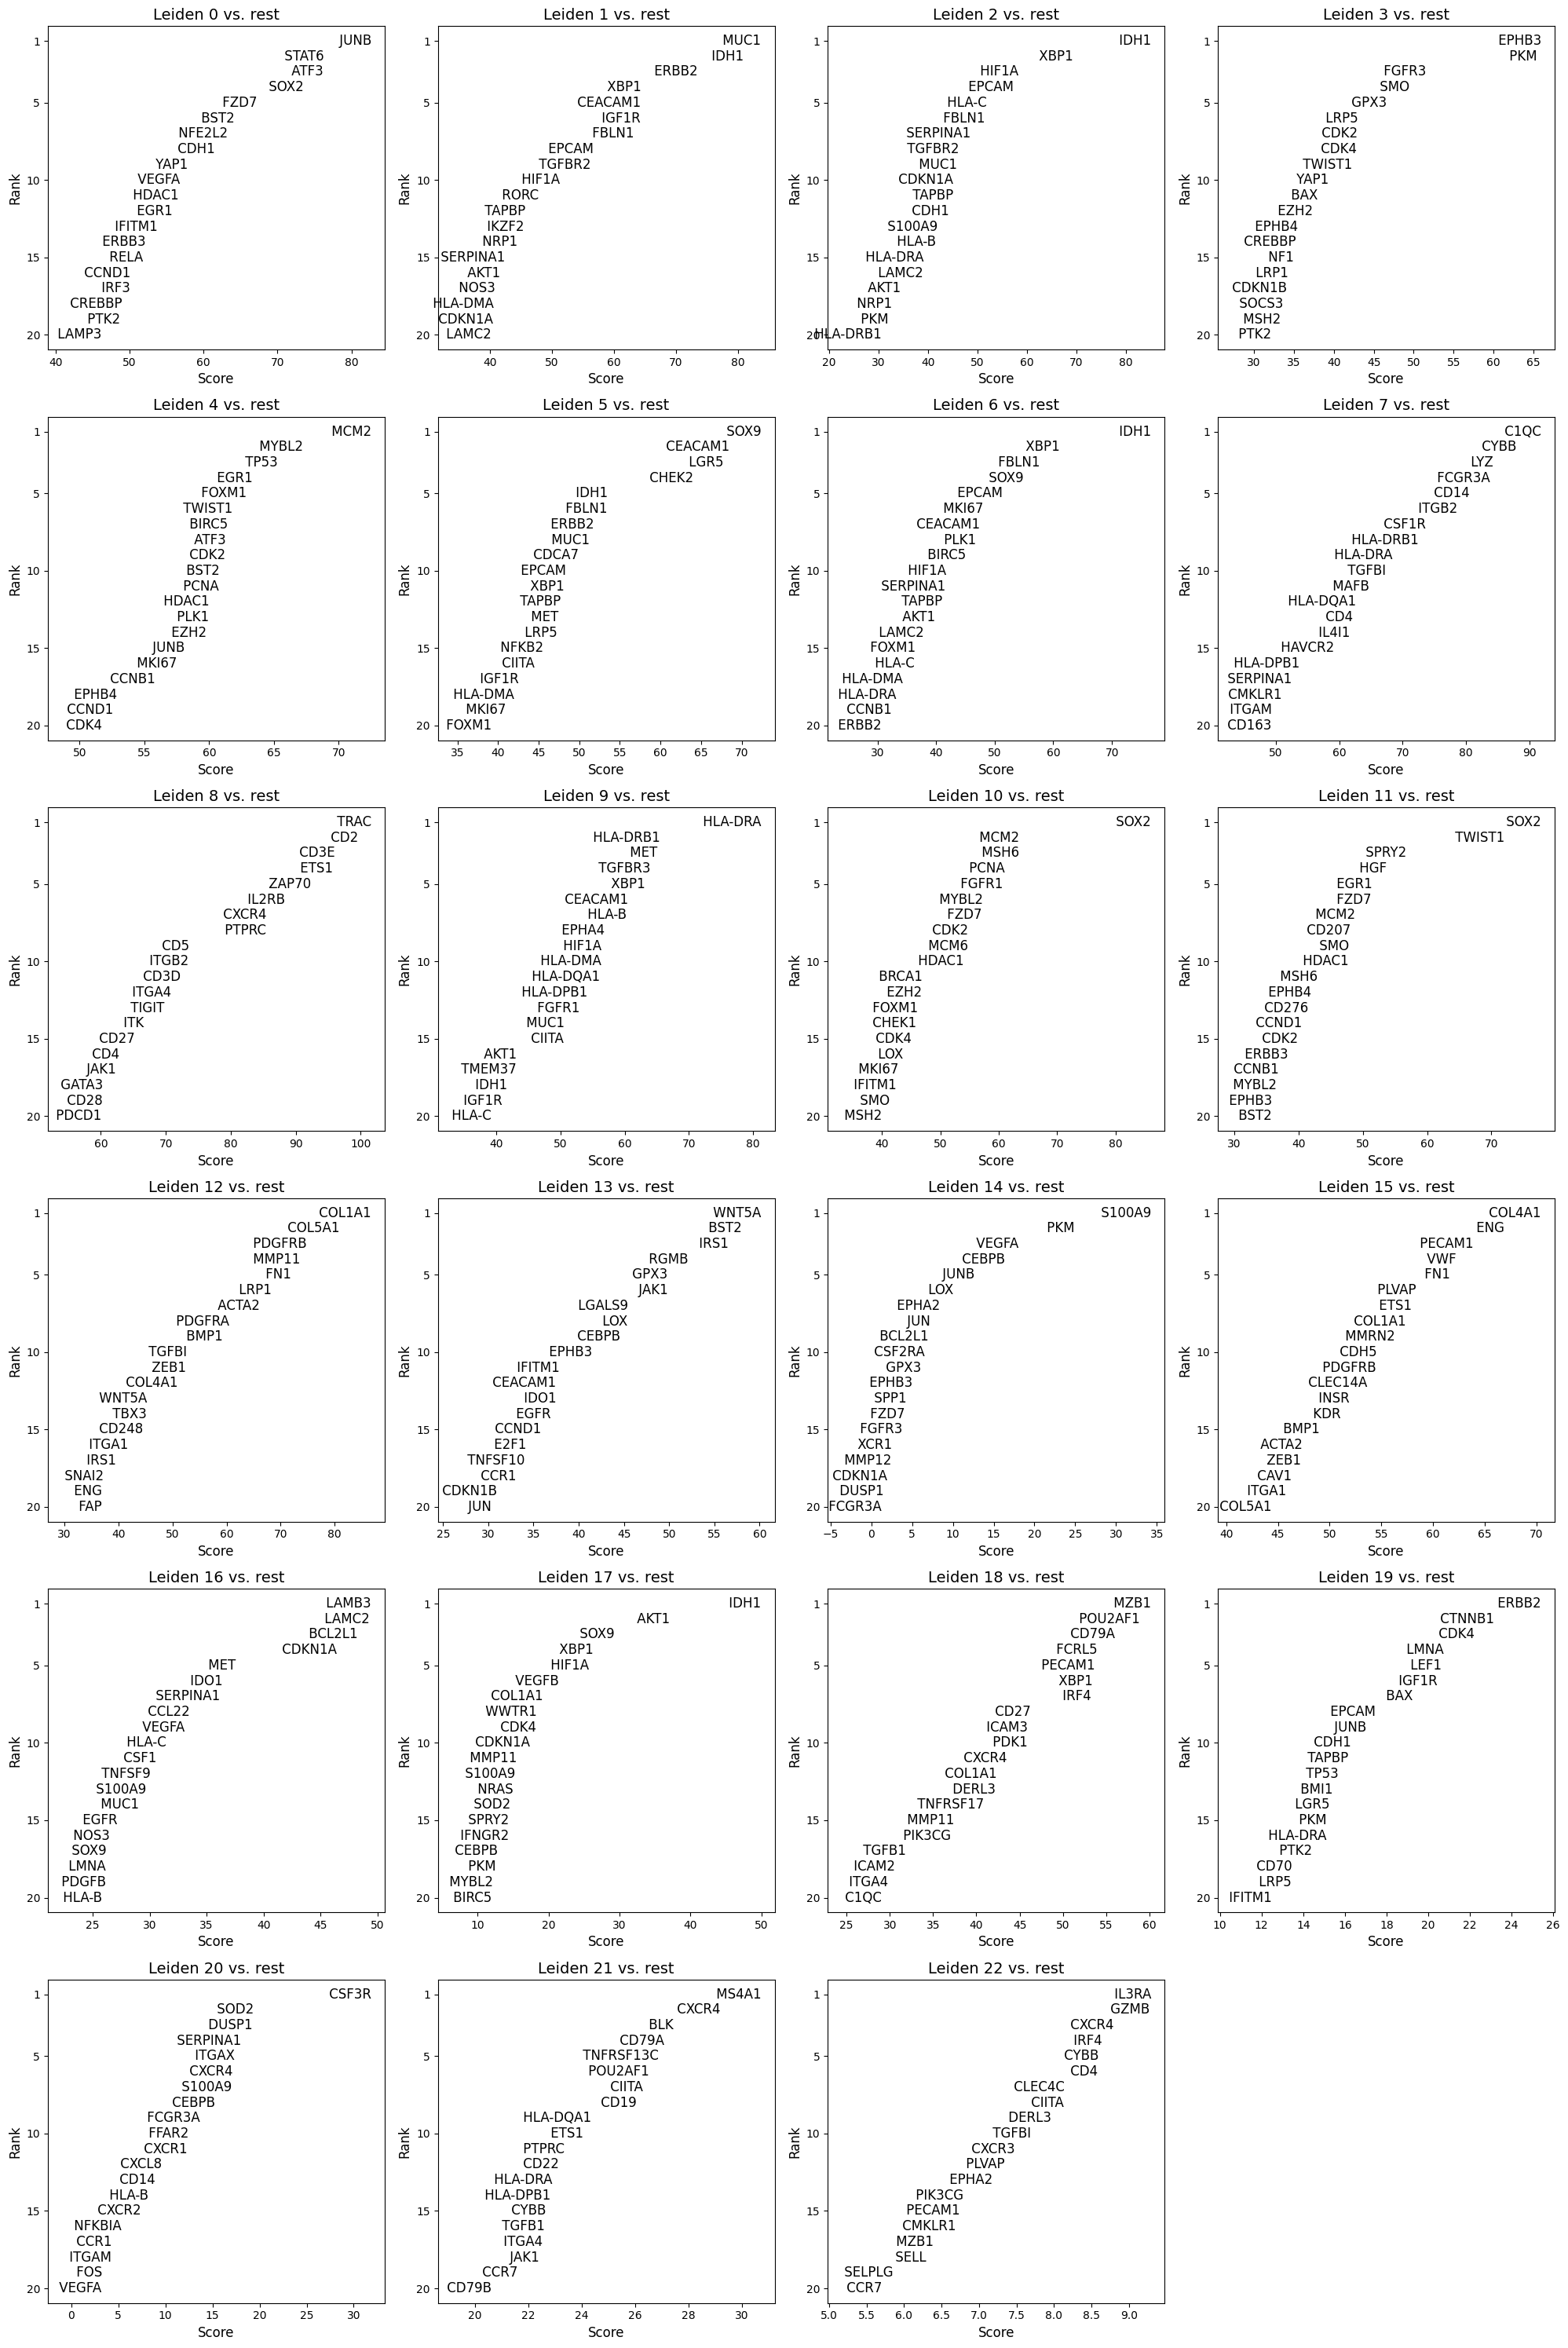

CPU times: user 14.7 s, sys: 92.9 ms, total: 14.7 s
Wall time: 14.8 s


In [11]:
%%time

# Rank genes (Differential expression)
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# sc.pl.rank_genes_groups(adata, n_genes=20, fontsize=12, ncols=3, sharey=False)

# Plot gene rank
# swop x and y axis to make gene names in horizontal for better visualization

# Number of clusters
n_clusters = len(adata.obs['leiden'].unique())
n_rows = 6
n_cols = 4
n_genes = 20  # Number of genes to visualize

# Define subplot size
subplot_width = 5  # Width of each subplot
subplot_height = 5  # Height of each subplot

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_width, n_rows * subplot_height))
axes = axes.flatten()  # Flatten the grid to iterate easily

# Loop over each Leiden cluster
for i in range(n_clusters):
    group = str(i)  # Leiden cluster name as a string
    ax = axes[i]  # Select the corresponding subplot

    # Extract rank genes information
    genes = adata.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = adata.uns['rank_genes_groups']['scores'][group][:n_genes]

    # Creating a DataFrame for ease of plotting
    data = pd.DataFrame({'Rank': range(1, n_genes + 1), 'Gene': genes, 'Score': scores})

    # Plotting on the subplot
    ax.scatter(data['Score'], data['Rank'], color='blue', s=0)  # Make dots invisible by setting size to 0
    ax.invert_yaxis()  # Invert y-axis to have rank 1 at the top

    # Adding gene name labels next to dots
    for j, row in data.iterrows():
        ax.text(row['Score'], row['Rank'], f" {row['Gene']}", va='center', ha='right', fontsize=12)

    # Adjusting y-axis to show only specific ranks
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_yticklabels([1, 5, 10, 15, 20])
    ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis tick size
    ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis tick size

    # Adjusting x-axis min
    xmin = data['Score'].min() - (data['Score'].max()-data['Score'].min())*.2
    ax.set_xlim(xmin, None)  # Set xmin, leaving xmax as automatic

    # Formatting the subplot
    ax.set_title(f'Leiden {group} vs. rest', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)

# Leave the last subplot blank
for i in range(n_clusters, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Plot ranking of genes using dotplot




    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


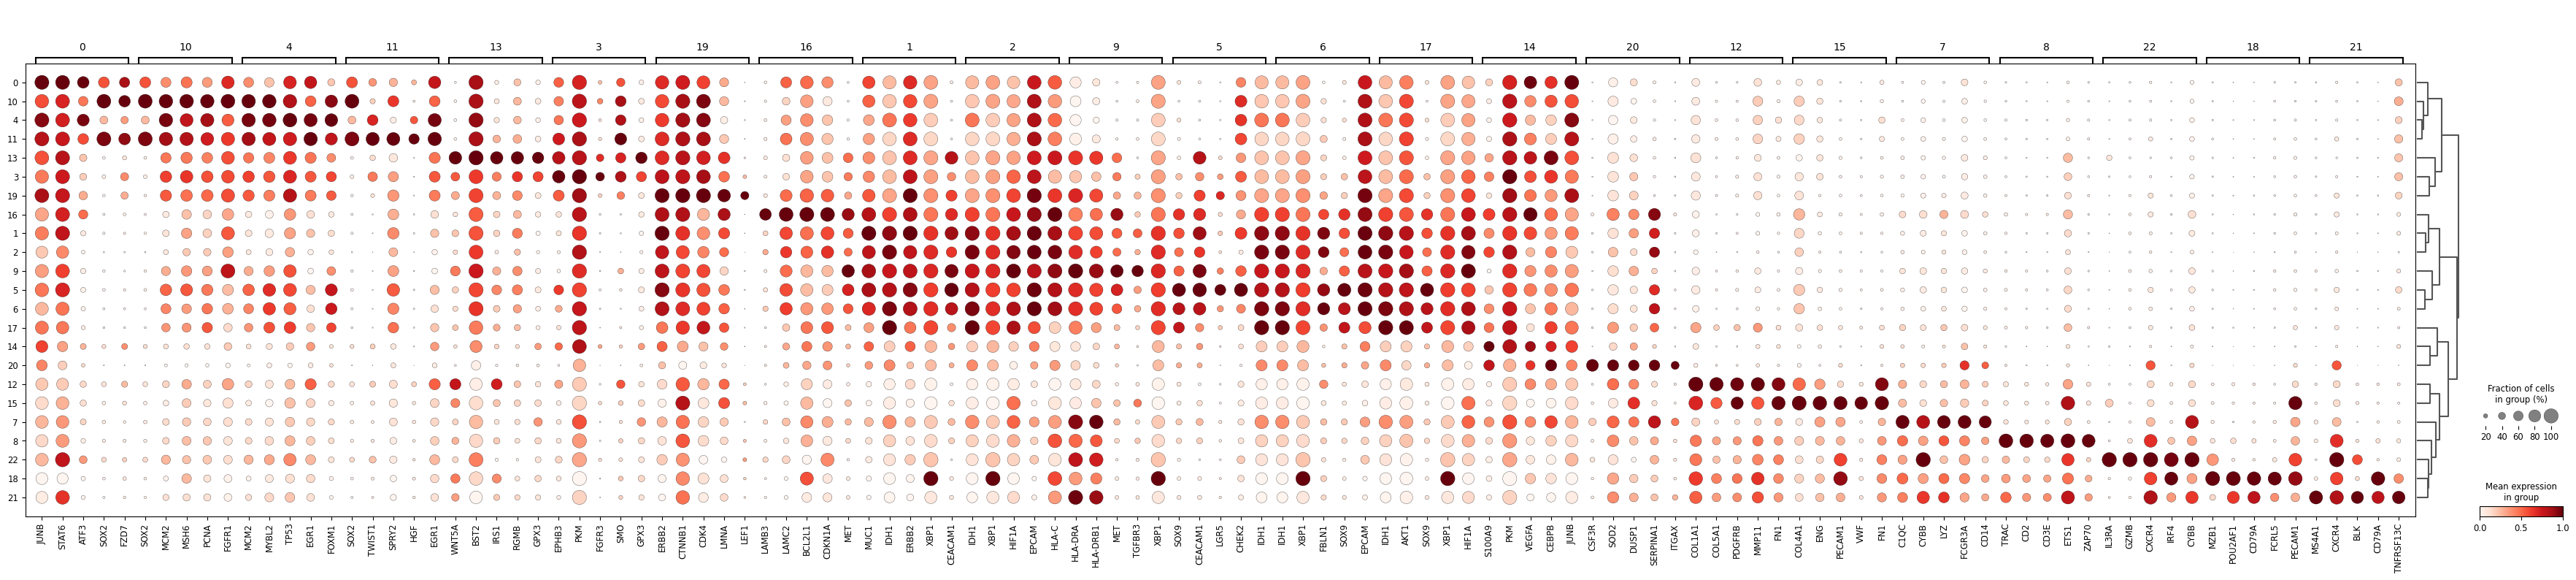

In [12]:
sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden',n_genes=5, standard_scale='var')

In [13]:
data_processing_time = time.time()
elapsed_seconds = data_processing_time - data_processing_start
elapsed_minutes = elapsed_seconds / 60

print("Total data processing time: %.2f minutes" % elapsed_minutes)


Total data processing time: 5.54 minutes


# **Step 4. Visualize clusters on UMAP and spatial distribution**

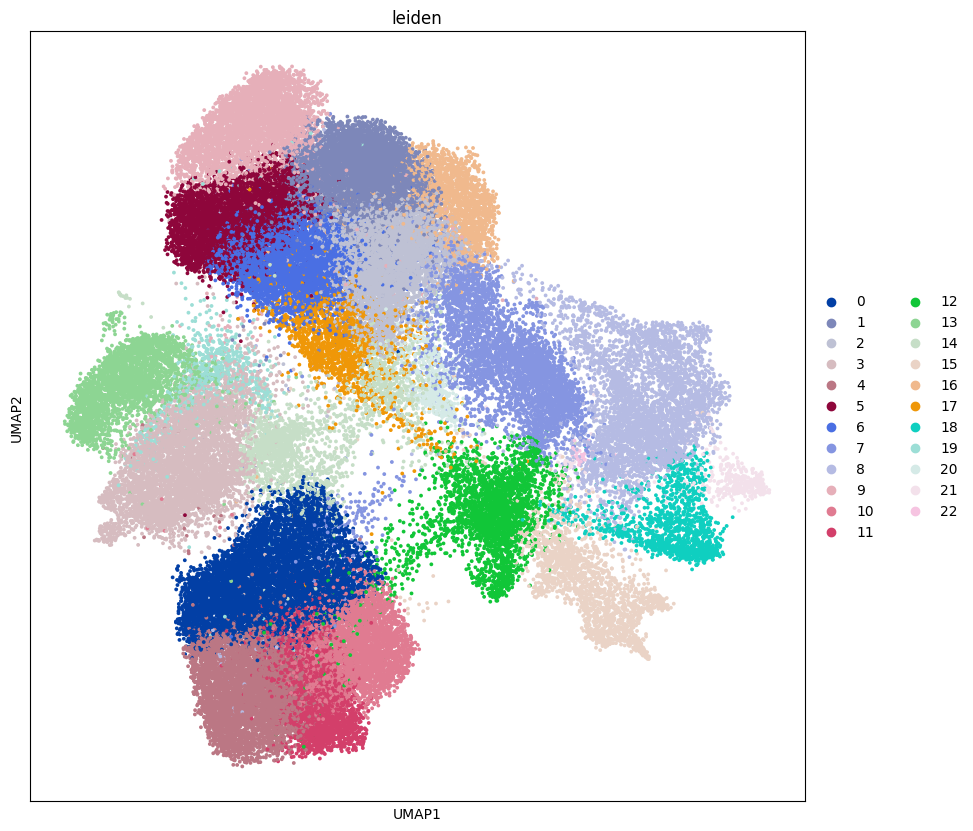

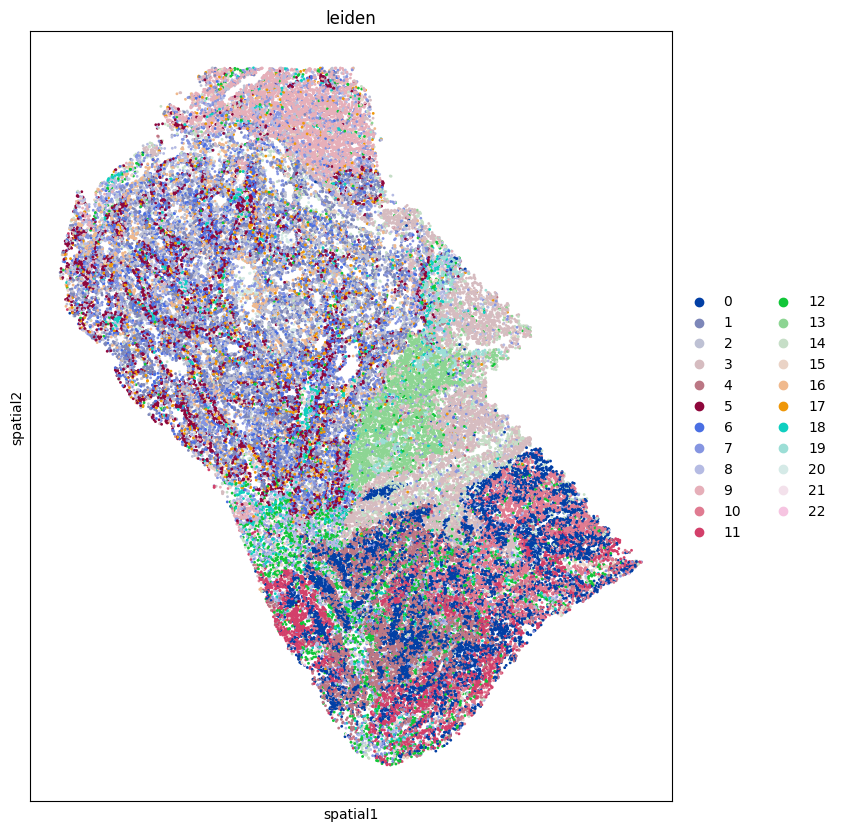

In [14]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color="leiden", size= 30, alpha = 1)

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color='leiden', spot_size=50, alpha = 1)

# Investigate the UMAP differences
Cell distribution on rapids-singlecell derived UMAP is different from the Scanpy workflow.

In [15]:
adata.layers["counts"]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 3, 1, ..., 0, 0, 6],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
adata.X

array([[ 0.75387357, -0.18907437, -0.34928569, ..., -0.1908873 ,
        -0.17959563, -1.00935469],
       [-0.68558511, -0.18907437,  2.01182504, ..., -0.1908873 ,
        -0.17959563,  0.07141567],
       [ 0.23905083,  6.82513619,  1.08488623, ..., -0.1908873 ,
        -0.17959563,  1.14475715],
       ...,
       [-0.68558511, -0.18907437, -0.34928569, ..., -0.1908873 ,
        -0.17959563, -1.00935469],
       [-0.68558511, -0.18907437, -0.34928569, ..., -0.1908873 ,
        -0.17959563,  0.10724007],
       [-0.68558511, -0.18907437, -0.34928569, ..., -0.1908873 ,
        -0.17959563, -1.00935469]])

## Check principle component (PC) loads

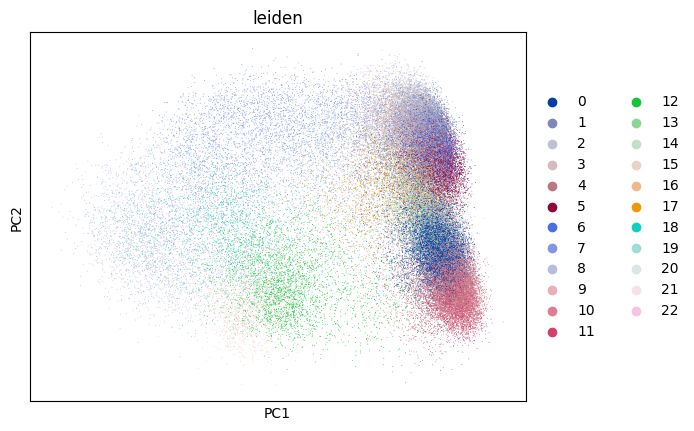

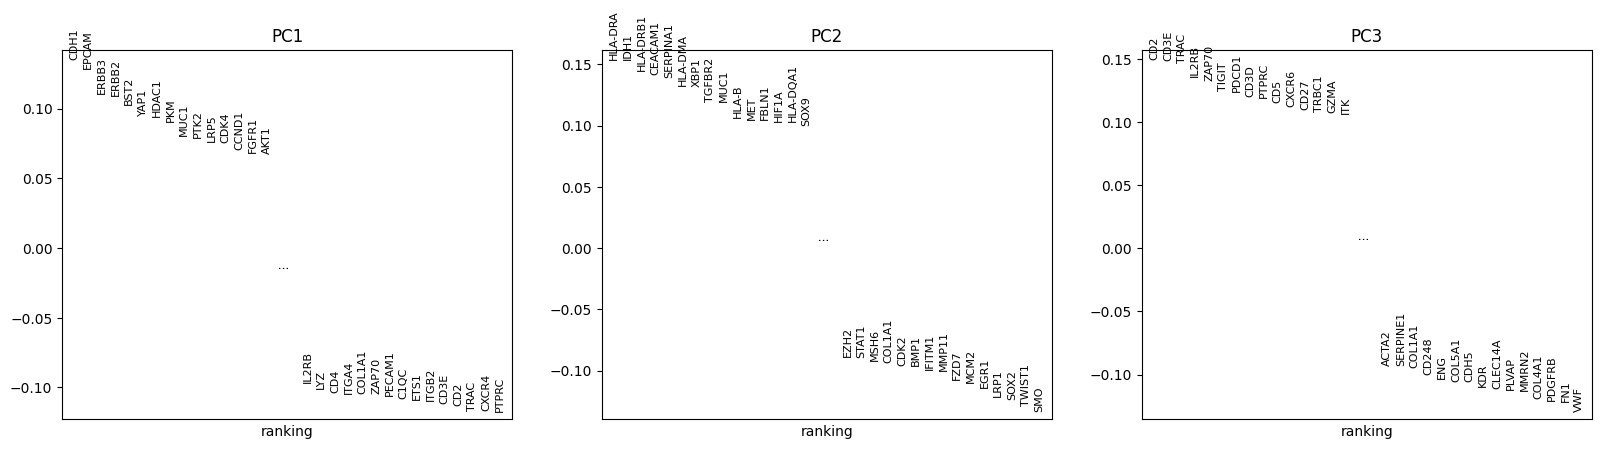

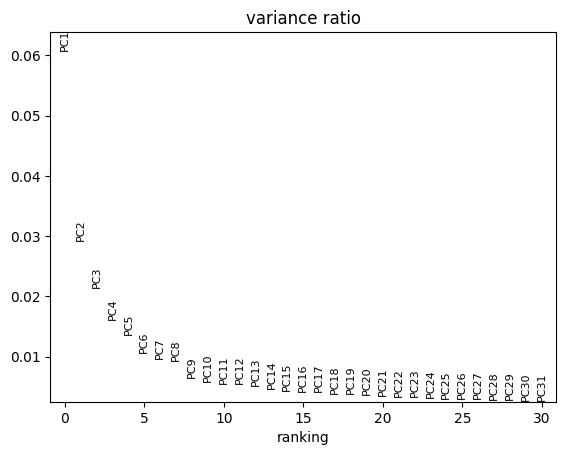

In [17]:
sc.pl.pca_overview(adata, color="leiden")

In [18]:
pc_df = pd.DataFrame(adata.varm['PCs'], index = adata.var_names)
pc_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
PDK4,-0.021155,0.055530,0.004383,0.008384,0.076991,-0.017841,0.026534,0.000419,0.027563,0.001802,...,-0.029602,-0.054158,-0.072148,0.020838,-0.036313,0.005656,0.006327,0.054791,-0.039635,-0.048613
CCL26,-0.003318,-0.005868,-0.005519,-0.003830,0.009923,-0.010140,-0.004559,-0.013804,0.011764,-0.020060,...,0.058498,0.043582,0.002702,-0.071510,0.072782,-0.141305,-0.024360,-0.060316,0.054746,0.068324
CX3CL1,-0.027215,-0.004745,-0.045057,-0.039508,0.012851,-0.038841,-0.029535,-0.063987,0.044214,-0.035180,...,0.000365,0.050625,0.000728,-0.039538,0.106666,0.170721,0.031369,0.045013,0.002675,-0.056289
PGLYRP1,-0.002342,-0.002686,0.005734,0.002331,0.014615,0.004516,-0.000424,-0.002463,0.002720,-0.012702,...,0.042514,0.017095,-0.027218,-0.023951,0.008166,-0.019122,0.035007,0.013357,0.001585,0.000656
CD4,-0.103488,0.023406,0.062505,0.067165,0.049669,0.022225,0.019845,-0.023327,-0.011702,-0.032521,...,-0.009429,0.020944,0.011724,-0.028355,0.013332,0.026127,0.024805,-0.015745,-0.001255,-0.010975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATM,-0.007903,-0.014290,0.027535,-0.012708,0.034892,-0.022331,-0.037659,-0.002912,0.001270,-0.001803,...,-0.008420,0.019898,-0.019852,0.037973,-0.041509,-0.033309,-0.063964,-0.008685,0.045138,0.068214
PRF1,-0.035391,0.002466,0.058518,-0.030395,-0.006382,0.033880,0.024676,-0.025705,0.009966,0.018261,...,-0.053288,0.004492,0.040244,-0.004628,0.042254,-0.022657,0.067473,0.017290,-0.022886,-0.030170
IL10,-0.020683,-0.007011,0.001785,0.014203,0.019093,-0.001875,0.000884,-0.018149,0.016967,-0.005639,...,0.030409,0.016384,-0.016109,-0.010860,-0.076918,-0.045395,0.044996,0.016122,-0.063703,-0.055621
IL17A,0.001492,-0.004315,0.004041,0.004649,0.015873,0.003902,0.002354,-0.000236,0.000731,-0.009571,...,0.044265,-0.007086,0.001649,-0.007789,0.036917,0.091387,0.008467,-0.059303,0.007841,0.097090


In [19]:
# rank PC1
display(pc_df[0].sort_values(ascending=False).head(20))
display(pc_df[0].sort_values(ascending=False).tail(20))

,0
CDH1,0.135305
EPCAM,0.128505
ERBB3,0.110768
ERBB2,0.108938
BST2,0.102433
YAP1,0.095076
HDAC1,0.093923
PKM,0.090780
MUC1,0.080674
PTK2,0.079209


,0
FN1,-0.091836
TGFBI,-0.092033
COL5A1,-0.093523
PDGFRB,-0.094006
CD27,-0.095631
IL2RB,-0.096675
LYZ,-0.101021
CD4,-0.103488
ITGA4,-0.104159
COL1A1,-0.104595


In [20]:
# rank PC2
display(pc_df[1].sort_values(ascending=False).head(20))
display(pc_df[1].sort_values(ascending=False).tail(20))

,1
HLA-DRA,0.154101
IDH1,0.153827
HLA-DRB1,0.144907
CEACAM1,0.141323
SERPINA1,0.138731
HLA-DMA,0.132695
XBP1,0.131522
TGFBR2,0.119792
MUC1,0.119683
HLA-B,0.106590


,1
AKT3,-0.082134
HGF,-0.082294
PCNA,-0.083525
CHEK1,-0.083768
IRF3,-0.083853
EZH2,-0.088557
STAT1,-0.089012
MSH6,-0.092144
COL1A1,-0.093796
CDK2,-0.095799


In [ ]:
# print out session information
!pip list